![intro](images/director_shot.jpeg)

# Movie Analysis
**Authors:** Ricardo Chin
***

## Overview

This project uses a [IMDB](https://www.imdb.com/) data set that was obtained from [Kaggle](https://www.kaggle.com/datasets), to execute a quick Exploratory analysis of the data in order to make informed suggestions about the movie industry environment. The project goal is to use basic querying and python coding to extract, transform, and display data.

### Business Promblem

CompanyXYZ has decided that they want to be part of the movie industry and create box office hits! However, they have little to no experience in the industry. The stakeholders are seeking insight and suggestions to help navigate their endeavor in order to improve confidence in making effective investments. 

## Data Understanding

The data is a zipped IMDB sqlite data set downloaded from Kaggle.  It consists of three tables, for the purposes of this project we will focus on two tables to obtain basic information on top performing films and analyze what attributes have contributed to the titles' success.

In [216]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pandasql import sqldf
from datetime import datetime

# Tells python to immediately draw plots
%matplotlib inline
# Allows pandas to run sql queries on dataframes
pysql = lambda q: sqldf(q, globals())

In [217]:
# Connecting to database
conn = sqlite3.connect('zippedData/movies.sqlite')
# building sql cursor
cur = conn.cursor()
# Checking for existing tables
table_names = cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""").fetchall()
table_names

[('movies',), ('sqlite_sequence',), ('directors',)]

In [218]:
# Querying movies table
q = """
SELECT * 
FROM movies
"""
data = cur.execute(q).fetchall()
columns = [x[0] for x in cur.description]
movies_df = pd.DataFrame(data=data, columns=columns)
movies_df.info()

# Querying directors table
q = """
SELECT * 
FROM directors
"""
data = cur.execute(q).fetchall()
columns = [x[0] for x in cur.description]
directors_df = pd.DataFrame(data=data, columns=columns)
directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4773 non-null   int64  
 1   original_title  4773 non-null   object 
 2   budget          4773 non-null   int64  
 3   popularity      4773 non-null   int64  
 4   release_date    4773 non-null   object 
 5   revenue         4773 non-null   int64  
 6   title           4773 non-null   object 
 7   vote_average    4773 non-null   float64
 8   vote_count      4773 non-null   int64  
 9   overview        4770 non-null   object 
 10  tagline         3951 non-null   object 
 11  uid             4773 non-null   int64  
 12  director_id     4773 non-null   int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 484.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ---

## Data Modeling

This project focuses on fiscal success to appeal to the stakeholders. The target variables will be revenues and earnings, our model will contain relevant features from both tables to analyze. Topics to analyze will be: revenue, original title, budget, popularity, release date,  vote average, vote count, director name, and director gender.  These features will help to translate what contributes to the success of these titles.

In [219]:
# We will query using a common table expression to join releative attributes from the directors table to the movies table while
# dropping unneccessary columns from the movies table

q = """
WITH directors_names AS (
SELECT name, id, gender
FROM directors_df)

SELECT movies_df.revenue, movies_df.original_title, movies_df.budget, movies_df.popularity, movies_df.release_date, movies_df.vote_average,
movies_df.vote_count, directors_names.name, directors_names.gender, directors_names.id
FROM movies_df
LEFT JOIN directors_names
ON movies_df.director_id = directors_names.id;
"""
df = pysql(q)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   revenue         4773 non-null   int64  
 1   original_title  4773 non-null   object 
 2   budget          4773 non-null   int64  
 3   popularity      4773 non-null   int64  
 4   release_date    4773 non-null   object 
 5   vote_average    4773 non-null   float64
 6   vote_count      4773 non-null   int64  
 7   name            4773 non-null   object 
 8   gender          4773 non-null   int64  
 9   id              4773 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 373.0+ KB


In [220]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.release_date.describe(datetime_is_numeric=True)

count                             4773
mean     2002-12-14 02:57:23.871778944
min                1916-09-04 00:00:00
25%                1999-06-18 00:00:00
50%                2005-09-23 00:00:00
75%                2011-02-11 00:00:00
max                2017-02-03 00:00:00
Name: release_date, dtype: object

From our describe object we can see that the range of titles that are in this data set span from 1916-2017

In [221]:
zero_dollars_budgeted = df[df['budget'] == 0].count(axis='rows')
less_than_a_mill = df[df['budget'] < 1000000].count()
print(f'Titles that reported 0 dollars for budget: {zero_dollars_budgeted}')
print(f'Titles that reported less than a million for budget: {less_than_a_mill}')

Titles that reported 0 dollars for budget: revenue           1014
original_title    1014
budget            1014
popularity        1014
release_date      1014
vote_average      1014
vote_count        1014
name              1014
gender            1014
id                1014
dtype: int64
Titles that reported less than a million for budget: revenue           1199
original_title    1199
budget            1199
popularity        1199
release_date      1199
vote_average      1199
vote_count        1199
name              1199
gender            1199
id                1199
dtype: int64


#### We also can see that their are titles that have reprted zero dollars for their budget. For the purpose of our company we will assume its interest is to create titles over a million in budgeting.

In [222]:
## Creates a new column called earnings by subtracting the budget column from revenue
df['earnings'] = df.apply(lambda row: row.revenue - row.budget, axis=1)

In [223]:
# Ridding dataframe of titles that reported less than a million in budget
df_cln_budgets = df[df['budget'] >= 1000000]
df_cln_budgets.shape

(3574, 11)

In [224]:
df_cln_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3574 entries, 0 to 4728
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   revenue         3574 non-null   int64         
 1   original_title  3574 non-null   object        
 2   budget          3574 non-null   int64         
 3   popularity      3574 non-null   int64         
 4   release_date    3574 non-null   datetime64[ns]
 5   vote_average    3574 non-null   float64       
 6   vote_count      3574 non-null   int64         
 7   name            3574 non-null   object        
 8   gender          3574 non-null   int64         
 9   id              3574 non-null   int64         
 10  earnings        3574 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 335.1+ KB


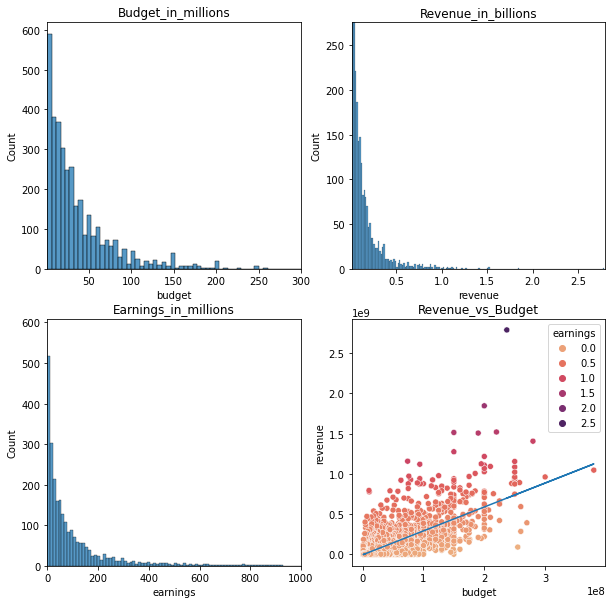

In [225]:
# Creates a figure with two rows and two columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

# Creates a density histogram for title budgets
ax1.set_xlim(left=1, right=300)
ax1.set(title='Budget_in_millions')
sns.histplot(x=(df_cln_budgets['budget']/1000000), ax=ax1)

# Creates a density histogram for title revenues
ax2.set_xlim(left=0.01, right=2.8)
ax2.set_ylim(top=275)
ax2.set(title='Revenue_in_billions')
sns.histplot(x=(df_cln_budgets['revenue']/1000000000), ax=ax2)

# Creates a density histogram for title earnings
ax3.set_xlim(0, 1000)
ax3.set(title='Earnings_in_millions')
sns.histplot(x=df_cln_budgets['earnings']/1000000, ax=ax3)

# Creates a scatterplot of title data points of budget vs revenue
# includes hue of earnings
m, b = np.polyfit(df_cln_budgets['budget'], df_cln_budgets['revenue'], 1)
ax4 = plt.plot(df_cln_budgets['budget'], m*df_cln_budgets['budget'] + b)
sns.scatterplot(x='budget', y='revenue', hue='earnings', data=df_cln_budgets, palette='flare').set(title='Revenue_vs_Budget')
plt.show()


In [226]:
budgets_corr = df_cln_budgets['revenue'].corr(df_cln_budgets['budget'])
earnings_corr = df_cln_budgets['earnings'].corr(df_cln_budgets['budget'])
print(f'independent var budgets to revenue correlation {budgets_corr}')
print(f'independent var budgets to earnings correlation {earnings_corr}')
      

independent var budgets to revenue correlation 0.7053678284717816
independent var budgets to earnings correlation 0.5510501921191312


In [227]:
df_cln_budgets['budget'].describe().apply(lambda x: format(x, 'f'))

count         3574.000000
mean      39011181.682429
std       42900126.062369
min        1000000.000000
25%       10000000.000000
50%       25000000.000000
75%       50000000.000000
max      380000000.000000
Name: budget, dtype: object

### Visualization Conclusion of a Fiscal Analysis

The graphs show film performance for those titles that spent at least a million in budgeting. 
There are a strong cluster of films that budgeted less than 50 million, however, there are also plenty of films that showed low to moderate revenue and earnings.  

Titles that budget in the Hundred million have stronger revenue streams and deeper shades of earning.
If company XYZ wants to be in the competitive sector of this industry, it will be suggested that their target budget is within that range.



In [228]:
df_cln_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3574 entries, 0 to 4728
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   revenue         3574 non-null   int64         
 1   original_title  3574 non-null   object        
 2   budget          3574 non-null   int64         
 3   popularity      3574 non-null   int64         
 4   release_date    3574 non-null   datetime64[ns]
 5   vote_average    3574 non-null   float64       
 6   vote_count      3574 non-null   int64         
 7   name            3574 non-null   object        
 8   gender          3574 non-null   int64         
 9   id              3574 non-null   int64         
 10  earnings        3574 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 335.1+ KB


<AxesSubplot:>

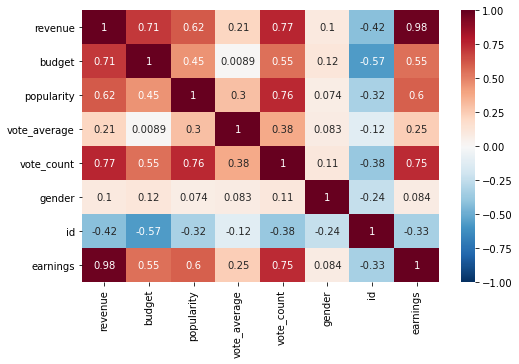

In [229]:
plt.figure(figsize=(8,5))
### Creates a Correlation graph that is color coded to highlight strong patterns against features of the dataset
sns.heatmap(df_cln_budgets.corr(), annot=True, cmap='RdBu_r', vmin=-1, vmax=1)

### Investigating directors


In [230]:
df['popularity'].describe()

count    4773.000000
mean       21.136602
std        31.864132
min         0.000000
25%         4.000000
50%        13.000000
75%        28.000000
max       875.000000
Name: popularity, dtype: float64

In [231]:
df.sort_values(by='popularity', ascending=False).head(20)

,revenue,original_title,budget,popularity,release_date,vote_average,vote_count,name,gender,id,earnings
546,1156730962,Minions,74000000,875,2015-06-17,6.4,4571,Kyle Balda,0,5045,1082730962
95,675120017,Interstellar,165000000,724,2014-11-05,8.1,10867,Christopher Nolan,2,4765,510120017
788,783112979,Deadpool,58000000,514,2016-02-09,7.4,10995,Tim Miller,2,5151,725112979
94,773328629,Guardians of the Galaxy,170000000,481,2014-07-30,7.9,9742,James Gunn,2,4827,603328629
127,378858340,Mad Max: Fury Road,150000000,434,2015-05-13,7.2,9427,George Miller,2,4845,228858340
28,1513528810,Jurassic World,150000000,418,2015-06-09,6.5,8662,Colin Trevorrow,2,4783,1363528810
199,655011224,Pirates of the Caribbean: The Curse of the Bla...,140000000,271,2003-07-09,7.5,6985,Gore Verbinski,2,4763,515011224
82,710644566,Dawn of the Planet of the Apes,170000000,243,2014-06-26,7.3,4410,Matt Reeves,2,4818,540644566
200,752100229,The Hunger Games: Mockingjay - Part 1,125000000,206,2014-11-18,6.6,5584,Francis Lawrence,2,4831,627100229
88,652105443,Big Hero 6,165000000,203,2014-10-24,7.8,6135,Chris Williams,2,4823,487105443


#### Popularity
Most of our films have a popularity count of 28 or less.  However, we have quiet a few signigicant titles that have popularity counts in the hundreds. 

In [232]:
## Creates a list of the top 20 directors by film earnings
most_earnings_directors = df_cln_budgets.groupby(['name'])['earnings'].sum().sort_values(ascending=False).head(20)
## Creates a list of the top 20 directors by acumalated popularity
most_popular_directors = df_cln_budgets.groupby(['name'])['popularity'].sum().sort_values(ascending=False).head(20)


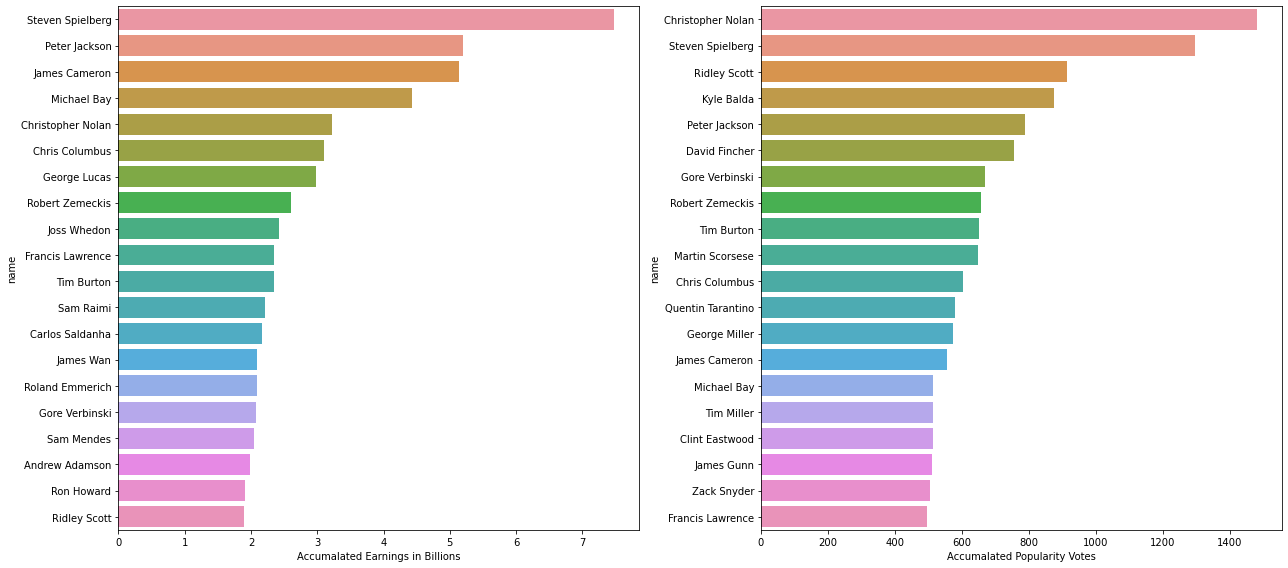

In [233]:
## Creates figure with two axis
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize = (18, 8))
ax1.set_xlabel('Accumalated Earnings in Billions')
sns.barplot(x=most_earning_directors.values/1000000000, y=most_earning_directors.index, ax=ax1)
ax2.set_xlabel('Accumalated Popularity Votes')
sns.barplot(x=most_popular_directors.values, y=most_popular_directors.index, ax=ax2)
fig.tight_layout()
plt.show()

In [234]:
def format_int_with_commas(x):
    """
    formats an integer with commas as thousand separators.
    """
    return f"{x:,}"


merged_top_directors = pd.merge(left=most_earning_directors, right=most_popular_directors, left_index=True, right_index=True)
merged_top_directors.applymap(format_int_with_commas)

,earnings,popularity
name,,
Steven Spielberg,"7,479,893,164","1,296"
Peter Jackson,"5,205,642,820",787
James Cameron,"5,136,669,439",554
Michael Bay,"4,422,524,638",514
Christopher Nolan,"3,222,483,234","1,480"
Chris Columbus,"3,098,631,503",603
Robert Zemeckis,"2,600,622,002",658
Francis Lawrence,"2,349,457,182",495
Tim Burton,"2,340,418,241",652


### Directors Conclusion
From our Correlation Heat Map we saw a low to moderate assocition with budgets and popularity. A closer look at directors does show some of the more popular directors have a the potential to earn billions for their studios.  The above top director list may be taken into consideration when Company XYZ decides to put together their first film.

## In Conclusion

From our budget analysis we concluded that titles that budgeted over a hundred million had greater revenue streams and stronger earning power.
We also concluded that choosing the right director can improve popularity and earnings for the film as well.

CompanyXYZ can create a strong and popular title with a budget of a hundred and twenty million and hire a director such as Robert Zemeckis.

#### Other things to consider
CompanyXYZ should now investigate film genres and perhaps their runtimes. Also, they may to find out industry leaders. Which studios are finding great success and what they are doing well.
